In [1]:
# Import packages
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time
import requests
import gzip
import os
import hashlib
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import ssl

In [11]:
# Dataset 1 - Cat vs non-cat, binary classification

train_dataset = h5py.File('train_catvnoncat.h5', "r")
train_x = np.array(train_dataset["train_set_x"][:])
train_y = np.array(train_dataset["train_set_y"][:])

Y = train_y.reshape((1, train_y.shape[0]))
train_x_flatten = train_x.reshape(train_x.shape[0], -1).T
X = train_x_flatten / 255.
X = X.astype(np.float32)
Y = Y.astype(np.float32)
X = (torch.from_numpy(X.T)).clone().detach().requires_grad_(True).T
Y = (torch.from_numpy(Y.T)).clone().detach().requires_grad_(True).T
Data_num ="Data1"

In [6]:
# Dataset 2 - MNIST digits, multi-categorical classification

## Available online at:

path = ''
def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
train_x = np.copy(X)
train_y = np.copy(Y)
Y = train_y.reshape(-1)
nb_classes = 10
Y = (np.eye(nb_classes)[Y]).T
X = X.reshape(X.shape[0], -1).T
Y = Y.astype(np.float32)
X = X.astype(np.float32)
X = (torch.from_numpy(X)).clone().detach().requires_grad_(True)
Y = (torch.from_numpy(Y)).clone().detach().requires_grad_(True)
Data_num = "Data2"

In [8]:
# Dataset 3 - Pima Indians Diabetes, binary classification
## Available online at:
## https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv
file_pd = pd.read_csv("pima-indians-diabetes.csv", sep = ",")
Data_file = file_pd.to_numpy()
train_x = Data_file[:, :8]
train_y = Data_file[:, 8:]
X = train_x.reshape(train_x.shape[0], -1).T
Y = train_y.T
Y = Y.astype(np.float32)
X = X.astype(np.float32)
X = (torch.from_numpy(X)).clone().detach().requires_grad_(True)
Y = (torch.from_numpy(Y)).clone().detach().requires_grad_(True)
Data_num = "Data3"

In [8]:
# Dataset 4 - Banknote, binary classification
## Available online at:
## https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt
file_pd = pd.read_csv("data_banknote_authentication.txt", sep = ",")
Data_file = file_pd.to_numpy()
train_x = Data_file[:, :4]
train_y = Data_file[:, 4:]
X = train_x.reshape(train_x.shape[0], -1).T
Y = train_y.T
Y = Y.astype(np.float32)
X = X.astype(np.float32)
X = (torch.from_numpy(X)).clone().detach().requires_grad_(True)
Y = (torch.from_numpy(Y)).clone().detach().requires_grad_(True)
Data_num = "Data4"

In [2]:
# Dataset 5 - Boston House Price, regression problem
## Available online at:
## https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.data
file_pd = pd.read_csv("housing.data", delim_whitespace = True, header = None)
Data_file = file_pd.to_numpy()
train_x = Data_file[:, :13]
train_y = Data_file[:, 13:]
X = train_x.reshape(train_x.shape[0], -1).T
Y = train_y.T
Y = Y.astype(np.float32)
X = X.astype(np.float32)
X = (torch.from_numpy(X)).clone().detach().requires_grad_(True)
Y = (torch.from_numpy(Y)).clone().detach().requires_grad_(True)
Data_num = "Data5"

In [9]:
# Specify dataset and its specific attributes

## Use CPU
!export CUDA_VISIBLE_DEVICES=""

## Loss goal
def C_limit(Data_num):
  if Data_num == "Data1":
    cost_lim = 0.3
    return cost_lim
  elif Data_num == "Data2":
    cost_lim = 3.2494
    return cost_lim
  elif Data_num == "Data3":
    cost_lim = 0.55
    return cost_lim
  elif Data_num == "Data4":
    cost_lim = 0.001
    return cost_lim
  elif Data_num == "Data5":
    cost_lim = 84.42
    return cost_lim

cost_lim = C_limit(Data_num)

## Cost calculation
def Cost_cal (Data_num, Y, A4):
  if Data_num == "Data5":
    cost = (1 / Y.shape[1]) * torch.sum((Y - A4)**2)
    cost = cost.detach().numpy()
    return cost
  else:
    cost = (-1 / Y.shape[1]) * torch.sum(torch.multiply(Y, torch.log(A4)) + torch.multiply(1 - Y, torch.log(1 - A4)))
    cost = cost.detach().numpy()
    return cost

## Output activation function
def L_layer(Data_num, Z4):
  if Data_num == "Data2":
    A4 = F.softmax(Z4, dim = 0)
    return A4
  elif Data_num == "Data5":
    A4 = Z4
    return A4
  else:
    A4 = 1 / (1 + torch.Tensor.exp(-Z4))
    return A4

## Cost plot y axis limits
if Data_num == "Data1":
  ylim_top = 0.7
  ylim_bottom = 0.3
elif Data_num == "Data2":
  ylim_top = 3.25
  ylim_bottom = 3.2490
elif Data_num == "Data3":
  ylim_top = 0.7
  ylim_bottom = 0.55
elif Data_num == "Data4":
  ylim_top = 0.01
  ylim_bottom = 0.001
elif Data_num == "Data5":
  ylim_top = 120
  ylim_bottom = 84.42

## Print shapes of X, Y, and number of training examples
print("Y shape: " + str(Y.shape))
print("X shape: " + str(X.shape))
print("Number of training examples: " + str(X.shape[1]))

Y shape: torch.Size([1, 1371])
X shape: torch.Size([4, 1371])
Number of training examples: 1371


In [14]:
# Initialize model parameters

## Set seed
torch.manual_seed(1)

## NN layers and learning rate
L = [torch.tensor([X.shape[0]]), torch.tensor([20]), torch.tensor([7]), torch.tensor([5]), torch.tensor([Y.shape[0]])]
learning_rate = 0.0001

## Initialize weights and biases
W_c = {}; W_p = {}; W_o = {}; b_c = {}; b_p = {}; b_o = {}
for l in range(1, len(L)):
  W_c["W_c%s" %(l)] = torch.randn(L[l], L[l-1])  * torch.sqrt(2. / L[l-1])
  W_p["W_p%s" %(l)] = W_c["W_c%s" %(l)].detach().clone()
  W_o["W_o%s" %(l)] = W_c["W_c%s" %(l)].detach().clone()
  b_c["b_c%s" %(l)] = torch.zeros((L[l], 1))
  b_p["b_p%s" %(l)] = b_c["b_c%s" %(l)].detach().clone()
  b_o["b_o%s" %(l)] = b_c["b_c%s" %(l)].detach().clone()

## Initialize cost lists
cost_list_c = []; cost_list_p = []; cost_list_o = []

In [16]:
# Conventional backpropagation

t0 = time.process_time()
i = 0
for i in range(100000):
    Z_c1 = torch.mm(W_c["W_c1"], X) + b_c["b_c1"]
    A_c1 = torch.maximum(torch.tensor([0]), Z_c1)
    Z_c2 = torch.mm(W_c["W_c2"], A_c1) + b_c["b_c2"]
    A_c2 = torch.maximum(torch.tensor([0]), Z_c2)
    Z_c3 = torch.mm(W_c["W_c3"], A_c2) + b_c["b_c3"]
    A_c3 = torch.maximum(torch.tensor([0]), Z_c3)
    Z_c4 = torch.mm(W_c["W_c4"], A_c3) + b_c["b_c4"]
    A_c4 = L_layer(Data_num, Z_c4)

    dZ_c4 = torch.subtract(A_c4, Y)
    dW_c4 = torch.mm(dZ_c4, A_c3.T) * (1. / A_c3.shape[1])
    db_c4 = torch.sum(dZ_c4, axis = 1, keepdims = True) * (1. / A_c3.shape[1])

    dA_c3 = torch.mm(W_c["W_c4"].T, dZ_c4)
    dZ_c3 = torch.clone(dA_c3)
    dZ_c3[Z_c3 <= 0] = 0
    dW_c3 = torch.mm(dZ_c3, A_c2.T) * (1. / A_c2.shape[1])
    db_c3 = torch.sum(dZ_c3, axis = 1, keepdims = True) * (1. / A_c2.shape[1])

    dA_c2 = torch.mm(W_c["W_c3"].T, dZ_c3)
    dZ_c2 = torch.clone(dA_c2)
    dZ_c2[Z_c2 <= 0] = 0
    dW_c2 = torch.mm(dZ_c2, A_c1.T) * (1. / A_c1.shape[1])
    db_c2 = torch.sum(dZ_c2, axis = 1, keepdims = True) * (1. / A_c1.shape[1])

    dA_c1 = torch.mm(W_c["W_c2"].T, dZ_c2)
    dZ_c1 = torch.clone(dA_c1)
    dZ_c1[Z_c1 <= 0] = 0
    dW_c1 = torch.mm(dZ_c1, X.T) * (1. / X.shape[1])
    db_c1 = torch.sum(dZ_c1, axis = 1, keepdims = True) * (1. / X.shape[1])

    W_c["W_c1"] = torch.subtract(W_c["W_c1"], learning_rate * dW_c1)
    b_c["b_c1"] = torch.subtract(b_c["b_c1"], learning_rate * db_c1)
    W_c["W_c2"] = torch.subtract(W_c["W_c2"], learning_rate * dW_c2)
    b_c["b_c2"] = torch.subtract(b_c["b_c2"], learning_rate * db_c2)
    W_c["W_c3"] = torch.subtract(W_c["W_c3"], learning_rate * dW_c3)
    b_c["b_c3"] = torch.subtract(b_c["b_c3"], learning_rate * db_c3)
    W_c["W_c4"] = torch.subtract(W_c["W_c4"], learning_rate * dW_c4)
    b_c["b_c4"] = torch.subtract(b_c["b_c4"], learning_rate * db_c4)

    cost_c = Cost_cal(Data_num, Y, A_c4)
    cost_c = np.squeeze(cost_c)
    cost_list_c.append(cost_c)

    if i % 3000 == 0:
        print("Cost for conventional backprop after iteration {}: {}".format(i, cost_c))
    
    if cost_c <= cost_lim:
        last_i_c = i
        print("Cost for conventional backprop after iteration {}: {}".format(i, cost_c))
        print("Number of epochs for conventional backprop: " + str(last_i_c))
        break
    else:
        continue

    i = i + 1

t1 = time.process_time() - t0
print("Time elapsed for conventional backprop: ", t1)

Cost for conventional backprop after iteration 0: 1.446103811264038
Cost for conventional backprop after iteration 3000: 0.25523650646209717
Cost for conventional backprop after iteration 6000: 0.1753489226102829
Cost for conventional backprop after iteration 9000: 0.1345432698726654
Cost for conventional backprop after iteration 12000: 0.11251409351825714
Cost for conventional backprop after iteration 15000: 0.09895753115415573
Cost for conventional backprop after iteration 18000: 0.08914992958307266


KeyboardInterrupt: 

In [15]:
# Optimized backpropagation

t4 = time.process_time()
k = 0
for k in range(10000):
    Z_o1 = torch.mm(W_o["W_o1"], X) + b_o["b_o1"]
    A_o1 = torch.maximum(torch.tensor([0]), Z_o1)
    Z_o2 = torch.mm(W_o["W_o2"], A_o1) + b_o["b_o2"]
    A_o2 = torch.maximum(torch.tensor([0]), Z_o2)
    Z_o3 = torch.mm(W_o["W_o3"], A_o2) + b_o["b_o3"]
    A_o3 = torch.maximum(torch.tensor([0]), Z_o3)
    Z_o4 = torch.mm(W_o["W_o4"], A_o3) + b_o["b_o4"]
    A_o4 = L_layer(Data_num, Z_o4)

    dZ_o4 = torch.subtract(A_o4, Y)
    dW_o4 = torch.mm(dZ_o4, A_o3.T) * (1. / A_o3.shape[1])
    db_o4 = torch.sum(dZ_o4, axis = 1, keepdims = True) * (1. / A_o3.shape[1])
    W_o["W_o4"] = torch.subtract(W_o["W_o4"], learning_rate * dW_o4)
    b_o["b_o4"] = torch.subtract(b_o["b_o4"], learning_rate * db_o4)
    Z_o4 = torch.mm(W_o["W_o4"], A_o3) + b_o["b_o4"]
    A_o4 = L_layer(Data_num, Z_o4)

    dZ_o4 = torch.subtract(A_o4, Y)
    dW_o4 = torch.mm(dZ_o4, A_o3.T) * (1. / A_o3.shape[1])
    db_o4 = torch.sum(dZ_o4, axis = 1, keepdims = True) * (1. / A_o3.shape[1])
    dA_o3 = torch.mm(W_o["W_o4"].T, dZ_o4)
    dZ_o3 = torch.clone(dA_o3)
    dZ_o3[Z_o3 <= 0] = 0
    dW_o3 = torch.mm(dZ_o3, A_o2.T) * (1. / A_o2.shape[1])
    db_o3 = torch.sum(dZ_o3, axis = 1, keepdims = True) * (1. / A_o2.shape[1])
    W_o["W_o3"] = torch.subtract(W_o["W_o3"], learning_rate * dW_o3)
    b_o["b_o3"] = torch.subtract(b_o["b_o3"], learning_rate * db_o3)
    W_o["W_o4"] = torch.subtract(W_o["W_o4"], learning_rate * dW_o4)
    b_o["b_o4"] = torch.subtract(b_o["b_o4"], learning_rate * db_o4)
    Z_o3 = torch.mm(W_o["W_o3"], A_o2) + b_o["b_o3"]
    A_o3 = torch.maximum(torch.tensor([0]), Z_o3)
    Z_o4 = torch.mm(W_o["W_o4"], A_o3) + b_o["b_o4"]
    A_o4 = L_layer(Data_num, Z_o4)

    dZ_o4 = torch.subtract(A_o4, Y)
    dW_o4 = torch.mm(dZ_o4, A_o3.T) * (1. / A_o3.shape[1])
    db_o4 = torch.sum(dZ_o4, axis = 1, keepdims = True) * (1. / A_o3.shape[1])
    dA_o3 = torch.mm(W_o["W_o4"].T, dZ_o4)
    dZ_o3 = torch.clone(dA_o3)
    dZ_o3[Z_o3 <= 0] = 0
    dW_o3 = torch.mm(dZ_o3, A_o2.T) * (1. / A_o2.shape[1])
    db_o3 = torch.sum(dZ_o3, axis = 1, keepdims = True) * (1. / A_o2.shape[1])
    dA_o2 = torch.mm(W_o["W_o3"].T, dZ_o3)
    dZ_o2 = torch.clone(dA_o2)
    dZ_o2[Z_o2 <= 0] = 0
    dW_o2 = torch.mm(dZ_o2, A_o1.T) * (1. / A_o1.shape[1])
    db_o2 = torch.sum(dZ_o2, axis = 1, keepdims = True) * (1. / A_o1.shape[1])
    W_o["W_o2"] = torch.subtract(W_o["W_o2"], learning_rate * dW_o2)
    b_o["b_o2"] = torch.subtract(b_o["b_o2"], learning_rate * db_o2)
    W_o["W_o3"] = torch.subtract(W_o["W_o3"], learning_rate * dW_o3)
    b_o["b_o3"] = torch.subtract(b_o["b_o3"], learning_rate * db_o3)
    W_o["W_o4"] = torch.subtract(W_o["W_o4"], learning_rate * dW_o4)
    b_o["b_o4"] = torch.subtract(b_o["b_o4"], learning_rate * db_o4)
    Z_o2 = torch.mm(W_o["W_o2"], A_o1) + b_o["b_o2"]
    A_o2 = torch.maximum(torch.tensor([0]), Z_o2)
    Z_o3 = torch.mm(W_o["W_o3"], A_o2) + b_o["b_o3"]
    A_o3 = torch.maximum(torch.tensor([0]), Z_o3)
    Z_o4 = torch.mm(W_o["W_o4"], A_o3) + b_o["b_o4"]
    A_o4 = L_layer(Data_num, Z_o4)

    dZ_o4 = torch.subtract(A_o4, Y)
    dW_o4 = torch.mm(dZ_o4, A_o3.T) * (1. / A_o3.shape[1])
    db_o4 = torch.sum(dZ_o4, axis = 1, keepdims = True) * (1. / A_o3.shape[1])
    dA_o3 = torch.mm(W_o["W_o4"].T, dZ_o4)
    dZ_o3 = torch.clone(dA_o3)
    dZ_o3[Z_o3 <= 0] = 0
    dW_o3 = torch.mm(dZ_o3, A_o2.T) * (1. / A_o2.shape[1])
    db_o3 = torch.sum(dZ_o3, axis = 1, keepdims = True) * (1. / A_o2.shape[1])
    dA_o2 = torch.mm(W_o["W_o3"].T, dZ_o3)
    dZ_o2 = torch.clone(dA_o2)
    dZ_o2[Z_o2 <= 0] = 0
    dW_o2 = torch.mm(dZ_o2, A_o1.T) * (1. / A_o1.shape[1])
    db_o2 = torch.sum(dZ_o2, axis = 1, keepdims = True) * (1. / A_o1.shape[1])
    dA_o1 = torch.mm(W_o["W_o2"].T, dZ_o2)
    dZ_o1 = torch.clone(dA_o1)
    dZ_o1[Z_o1 <= 0] = 0
    dW_o1 = torch.mm(dZ_o1, X.T) * (1. / X.shape[1])
    db_o1 = torch.sum(dZ_o1, axis = 1, keepdims = True) * (1. / X.shape[1])
    W_o["W_o1"] = torch.subtract(W_o["W_o1"], learning_rate * dW_o1)
    b_o["b_o1"] = torch.subtract(b_o["b_o1"], learning_rate * db_o1)
    W_o["W_o2"] = torch.subtract(W_o["W_o2"], learning_rate * dW_o2)
    b_o["b_o2"] = torch.subtract(b_o["b_o2"], learning_rate * db_o2)
    W_o["W_o3"] = torch.subtract(W_o["W_o3"], learning_rate * dW_o3)
    b_o["b_o3"] = torch.subtract(b_o["b_o3"], learning_rate * db_o3)
    W_o["W_o4"] = torch.subtract(W_o["W_o4"], learning_rate * dW_o4)
    b_o["b_o4"] = torch.subtract(b_o["b_o4"], learning_rate * db_o4)

    cost_o = Cost_cal(Data_num, Y, A_o4)
    cost_o = np.squeeze(cost_o)
    cost_list_o.append(cost_o)

    if k % 3000 == 0:
        print("Cost for conventional backprop after iteration {}: {}".format(k, cost_o))
    
    if cost_o <= cost_lim:
        last_k_o = k
        print("Cost for conventional backprop after iteration {}: {}".format(k, cost_o))
        print("Number of epochs for conventional backprop: " + str(last_k_o))
        break
    else:
        continue

    k = k + 1

t5 = time.process_time() - t4
print("Time elapsed for optimized backprop: ", t5)

Cost for optimized backprop after iteration 0: 1.4425677061080933
Cost for optimized backprop after iteration 3000: 0.15914900600910187
Cost for optimized backprop after iteration 6000: 0.10831081122159958
Cost for optimized backprop after iteration 9000: 0.08705426752567291
Time elapsed for optimized backprop:  54.444136000000015


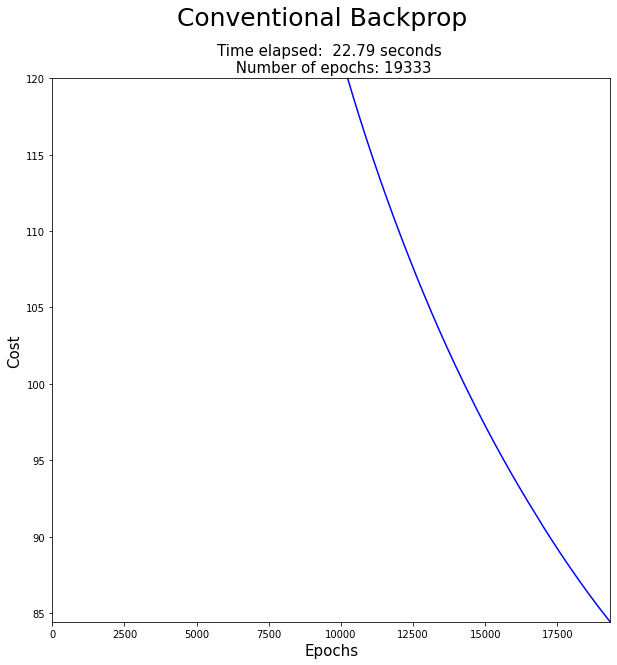

NameError: name 'last_k_o' is not defined

<Figure size 720x720 with 0 Axes>

In [7]:
# Plot cost functions

plt.figure(figsize = (10, 10))
plt.suptitle('Conventional Backprop', fontsize=25)
plt.title(f"Time elapsed: {t1: .2f} seconds \n Number of epochs: {last_i_c}", fontsize = 15)
plt.plot(list(range(last_i_c + 1)), cost_list_c, color = 'blue')
plt.ylim(bottom = ylim_bottom, top = ylim_top)
plt.xlim(left = 0, right=last_i_c + 5)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)
plt.show()

print()

plt.figure(figsize = (10, 10))
plt.suptitle('Optimized Backprop', fontsize = 25)
plt.title(f"Time elapsed: {t5:.2f} seconds \n Number of epochs: {last_k_o}", fontsize = 15)
plt.plot(list(range(last_k_o + 1)), cost_list_o, color = 'red')
plt.ylim(bottom = ylim_bottom, top = ylim_top)
plt.xlim(left = 0, right = last_i_c + 5)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)
plt.show()

In [ ]:
# Optional: PyTorch implementation

## Construct PyToch model
class Data(Dataset):
  # Constructor
  def __init__(self, X, Y):
    self.x = X
    self.y = Y
    self.len = self.x.shape[0]  
  # Getter
  def __getitem__(self, index):
    return self.x[index], self.y[index]
  # Get Length
  def __len__(self):
    return self.len

class CBP(nn.Module):
  def __init__(self, layer_dims):
    super(CBP, self).__init__()
    self.l1 = nn.Linear(layer_dims[0], layer_dims[1])
    self.l2 = nn.Linear(layer_dims[1], layer_dims[2])
    self.l3 = nn.Linear(layer_dims[2], layer_dims[3])
    self.l4 = nn.Linear(layer_dims[3], layer_dims[4])
  def forward(self, x):
    x = torch.relu(self.l1(x))
    x = torch.relu(self.l2(x))
    x = torch.relu(self.l3(x))
    x = torch.sigmoid(self.l4(x))
    return x

def train(model, criterion, x, y, optimizer, cost_lim):
  cost_list_p = []
  cost = 0
  j = 0
   
  for i in range(10000):
    optimizer.zero_grad()
    yhat = model(x)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cost = loss.item()
    cost_list_p.append(cost)
    if j % 100 == 0:
      print("Cost for PyTorch backprop after iteration {}: {}".format((j), cost))
    j += 1
    if cost < cost_lim:
      last_j_p = j
      print("Cost for PyTorch backprop after iteration {}: {}".format((j), cost))
      print("Number of epochs for PyTorch backprop: " + str(last_j_p))
      break
  return cost_list_p, last_j_p

model = CBP(L)

model.l1.weight = torch.nn.parameter.Parameter(W_p["W_p1"].float())
model.l1.bias = torch.nn.parameter.Parameter(b_p["b_p1"][0].float())
model.l2.weight = torch.nn.parameter.Parameter(W_p["W_p2"].float())
model.l2.bias = torch.nn.parameter.Parameter(b_p["b_p2"][0].float())
model.l3.weight = torch.nn.parameter.Parameter(W_p["W_p3"].float())
model.l3.bias = torch.nn.parameter.Parameter(b_p["b_p3"][0].float())
model.l4.weight = torch.nn.parameter.Parameter(W_p["W_p4"].float())
model.l4.bias = torch.nn.parameter.Parameter(b_p["b_p4"][0].float())

data_set = Data(X, Y)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

t2 = time.process_time()

cost_list_p, last_j_p = train(model, criterion, X.T, Y.T, optimizer, cost_lim)

t3 = time.process_time() - t2
print("Time elapsed for PyTorch backprop: ", t3)
print()

plt.figure(figsize = (10, 10))
plt.suptitle('PyTorch Backprop', fontsize = 25)
plt.title(f"Time elapsed: {t3: .2f} seconds \n Number of epochs : {last_j_p}", fontsize = 15)
plt.plot(list(range(last_j_p)), cost_list_p, color = 'green')
plt.ylim(bottom = ylim_bottom, top = ylim_top)
plt.xlim(left = 0, right = last_i_c + 5)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Cost", fontsize = 15)
plt.show()